本の中で引用されているPython用コードを載せています．
本サイトの内容は，随時修正いたします．

本サイトのソースコードは自由に使用，改変，配布することが可能です．

# 速度論

## [K1] ミカエリス-メンテンモデル

3.2節参照．

KM =  5.1


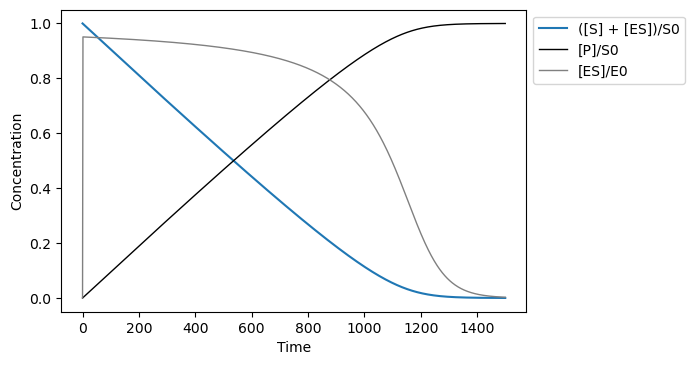

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

def mm(var, t, kon, koff, k):  # ミカエリス-メンテンモデル
    S, ES, P = var
    E = E0 - ES
    dSdt = -kon*E*S + koff*ES
    dESdt = kon*E*S - koff*ES - k*ES
    dPdt =  k*ES

    return [dSdt, dESdt, dPdt]

kon, koff, k = 1, 5, 0.1  # 書籍では kon, koffは k+, k- に対応します．
S0, E0 =100, 1  # 全濃度

t = np.linspace(0, 1500, 1000)
init = [S0, 0, 0] # 初期値
r = odeint(mm, init, t, args = (kon, koff, k)) # 微分方程式を解く

print("KM = ", (koff + k)/kon)  # ミカエリス定数

plt.figure(figsize = (6,4), dpi = 100)

plt.plot(t, (r[:,0]+r[:,1]) / S0, label = '([S] + [ES])/S0')
plt.plot(t, r[:,2] / S0, label = '[P]/S0', linewidth = 1, color = 'black')
plt.plot(t, r[:,1] / E0, label = '[ES]/E0', linewidth = 1, color = 'gray')
plt.legend(bbox_to_anchor=(1, 1))

plt.ylabel('Concentration')
plt.xlabel('Time')

plt.show()

## [K2] ヘモグロビン

ポーリングモデル．横軸は酸素分圧です．

3.6節参照．

n(fit) =  1.0 , kd(fit) =  0.3678794411714423
n(fit) =  1.9500137032893272 , kd(fit) =  0.081880980705429
n(fit) =  3.193393743260293 , kd(fit) =  0.01831563741960137


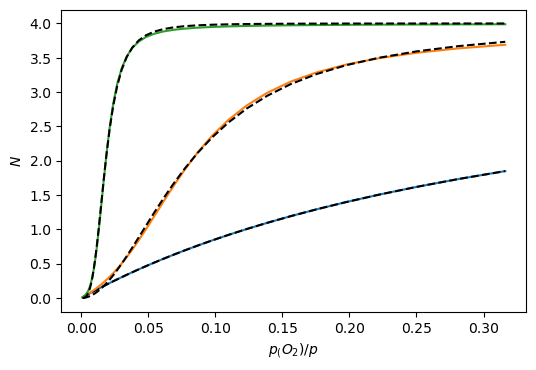

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def f(epsilon, mu, J):    # ポーリングモデル
    X = np.exp(-epsilon + mu)
    Y = np.exp(-J)
    
    Z = 1 + 4*X + 6*X*X*Y + 4*X*X*X*Y*Y*Y + X*X*X*X*Y*Y*Y*Y*Y*Y
    N = (4*X + 12*X*X*Y + 12*X*X*X*Y*Y*Y + 4*X*X*X*X*Y*Y*Y*Y*Y*Y)/Z
    
    return N

def hill(x, n, kd):    # ヒル関数（フィッティング用）
    return 4/(1+np.power(kd, n)/np.power(x, n))

epsilon = -1

p = np.logspace(-3, -0.5, base = 10)  # 酸素分圧
mu = np.log(p)

plt.figure(figsize=(6, 4) ,dpi = 100)

for J in [0, -1, -2]:
    N = f(epsilon, mu, J)
    (n_fit, kd_fit), cov = curve_fit(hill, p, N, p0 = [2, 0.01]) # ヒルの式によるフィット
    fit = hill(p, n_fit, kd_fit)
    
    plt.plot(p, N)
    plt.plot(p, fit, color = 'black', linestyle = 'dashed')
    print('n(fit) = ', n_fit, ', kd(fit) = ', kd_fit)
    
plt.ylabel(r'$N$')
plt.xlabel(r'$p_(O_2) / p$')

plt.show()

# 熱揺らぎと拡散

## [F1] ランダムウォーク

自由空間でのランダムウォークと，そのMSDプロット．

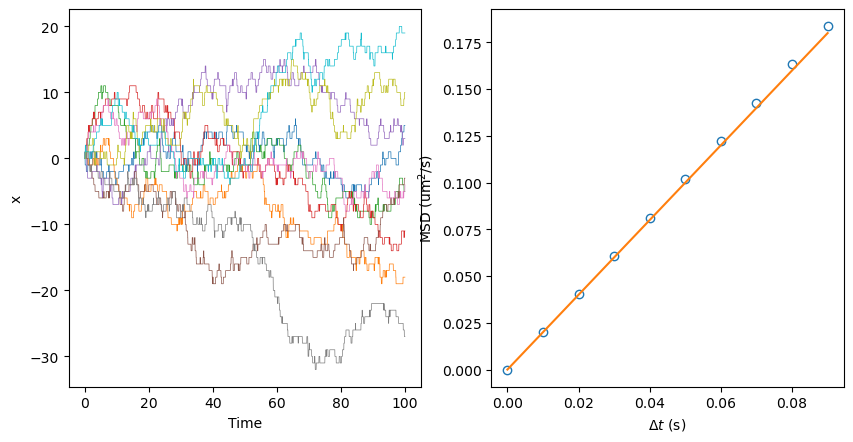

In [7]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    

# ランダムウォーク．p: １ステップあたりの確率．N: ステップの数．
def randomwalk(tau, w, d, N):     
    r = np.random.rand(N)
       
    x = np.zeros(N)
    x[0] = 0 # 初期位置
    p = w*tau
    for i in range(N-1): # ここはリストのまま計算すればかなり高速化できますが，分かりやすくするため，逐次的に計算しています．
        if r[i]<p:
            x[i + 1] = x[i]  + d
        elif r[i]<2*p:
            x[i + 1] = x[i]  - d  
        else:
            x[i + 1] = x[i]
    t = np.linspace(0, (N-1)*tau, N)
    
    return t, x

# 時系列 x[] のMSDを計算する（点の数 = msdN）．
def MSD(x, msdN):
    msd = np.zeros(msdN)
    n = len(x)  # 点の数
    for m in range(0, msdN):   
        dx = (x[m:n:1] - x[0:n-m:1])**2  # m*dt だけ離れた2点間の差の2乗を足していく．
        msd[m] += dx.sum() / len(dx)
    return msd


fig = plt.figure(figsize=(10,5), dpi=100)

ax1 = fig.add_subplot(121, xlabel = 'Time', ylabel = 'x')

# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
tau = 0.01 # サイコロを振る時間間隔
d = 1 # 1歩で進む距離
w = 1 # 単位時間当たりの遷移率
N = 10000 # ステップ数
msdN = 10 # MSDを計算する点の数
msd = np.zeros(msdN)
for i in range(10):
    t, x = randomwalk(tau, w, d, N) 
    ax1.plot(t, x, lw = 0.5)  # lwは線の太さ．
    
    msd += MSD(x, msdN)  # MSDの計算
msd /= 10

# MSDのプロット
dt = np.linspace(0, (msdN-1)*tau, msdN)
D = w*d*d  # 拡散係数
theory = 2*D*dt   # 理論曲線   MSD = 2DΔt

ax2 = fig.add_subplot(122, xlabel = r'$\Delta t$ (s)', ylabel = r'MSD (um$^2$/s)')
ax2.plot(dt, msd, 'o', markerfacecolor='none')
ax2.plot(dt, theory) 

plt.show()

## [F2] 自己相関関数

5.8節参照．

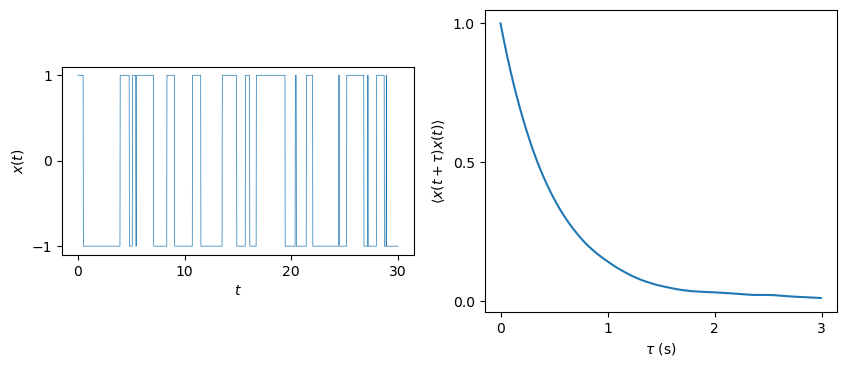

In [8]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    

# ランダムウォーク．p: １ステップあたりの確率．N: ステップの数．
def randomwalk(tau, w, d, N):  # 1, -1の間をランダムに行き来する．   
    r = np.random.rand(N)
       
    x = np.zeros(N)
    x[0] = 1 # 初期位置
    p = w*tau
    for i in range(N-1):
        if r[i]<p:
            x[i + 1] = -x[i]
        else:
            x[i + 1] = x[i]
    t = np.linspace(0, (N-1)*tau, N)
    
    return t, x

# 時系列 x[] の自己相関関数を計算する（点の数 = M）．
def Corr(x, M):
    c = np.zeros(M)
    n = len(x)  # 点の数
    for m in range(0, M):   
        d = x[m:n-1] * x[0:n-m-1]  
        c[m] = d.sum() / len(d)
    return c


fig = plt.figure(figsize=(10,4), dpi=100)

# 同じ計算を10回して重ねてプロット．まとめて，MSDを計算．
tau = 0.01 # サイコロを振る時間間隔
d = 1 # 1歩で進む距離
w = 1 # 単位時間当たりの遷移率
N = 1000000 # ステップ数
M = 300 # 自己相関関数を計算する点の数
    
t, x = randomwalk(tau, w, d, N) 

plotN = 3000 # プロットするの点の数
ax1 = fig.add_subplot(121, xlabel = r'$t$', ylabel = r'$x(t)$')
ax1.plot(t[:plotN], x[:plotN], lw = 0.5)  # lwは線の太さ．
ax1.set_xticks([0, 10, 20, 30])
ax1.set_yticks([-1, 0, 1])
ax1.set_aspect(8)

dt = np.linspace(0, (M-1)*tau, M)
C = Corr(x, M)  # 自己相関関数の計算

ax2 = fig.add_subplot(122, xlabel = r'$\tau$ (s)', ylabel = r'$\langle x(t+\tau)x(t)\rangle$')
ax2.plot(dt, C, '-', markerfacecolor='none')
ax2.set_xticks([0,1,2,3])
ax2.set_yticks([0,0.5,1])

plt.show()

fig.savefig("fig.eps", bbox_inches="tight",pad_inches=0.05)

## [F3] 拡散方程式

5.11節参照．

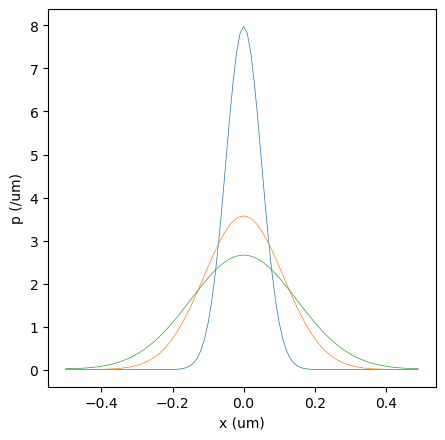

In [183]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

# 拡散方程式を解く．
def diffusionequation(dt, dx, T, L, D):  # 時間刻み dt で T だけ計算．慶のサイズは L, 空間の刻み幅 dx, 拡散係数 D．  
    n = int(T / dt)  # ステップ数
    nx = int(L/dx) # 空間の分割数
    
    # 初期分布．幅dの正規分布
    x = np.linspace(-L/2, L/2-dx, nx)
    d = 0.5E-7
    p = np.exp(-0.5*(x/d)**2)/np.sqrt(2*np.pi*d*d)
    
    # 拡散方程式に従って時間発展
    for i in range(n):
        diff = D*(np.roll(p, 1) - 2*p + np.roll(p,-1))/dx/dx  # 拡散項
        p += diff*dt
    
    return x, p


# パラメータ設定
D = 1E-16 # m^2/s
  
L = 1E-6
dx = L/100
dt = 1E-2 # (s) 計算の時間刻み

plt.figure(figsize=(5,5), dpi=100)
for T in [0, 50, 100]: # 時間を変えて計算．
    x, p = diffusionequation(dt, dx, T, L, D)  # ランジュバン方程式による計算
    plt.plot(x*1E6, p*1E-6, lw = 0.5)  # lwは線の太さ．
        
plt.xlabel('x (um)')
plt.ylabel('p (/um)')

plt.show()

## [F4] 調和ポンテシャル中のブラウン粒子(ランジュバン方程式)

ランジュバン方程式：
$$\gamma \dot x=-kx+\xi,\qquad \langle \xi(t)\xi(s)\rangle=2k_\mathrm{B}T\gamma\delta(t-s).$$
これを差分すると，
$$x_{n+1}-x_{n}=-\frac k\gamma x_n\Delta t+w r_n,\qquad w=\sqrt{\frac{2k_\mathrm{B}T}\gamma\Delta t}.$$
ただし，$r_n$は正規分布に従う乱数（平均0, 分散1）．
熱揺動力の項では，ルートの中に$\Delta t$が入ることに注意．

ばね定数 $k$, 摩擦係数 $\gamma$では，時定数 $\tau=\frac \gamma k$ で平衡状態に緩和する．また，このバネ＋摩擦の系はローパスフィルタ―とみなすこともでき，$\tau$ よりも短い時間スケールの運動はなまってしまう． 


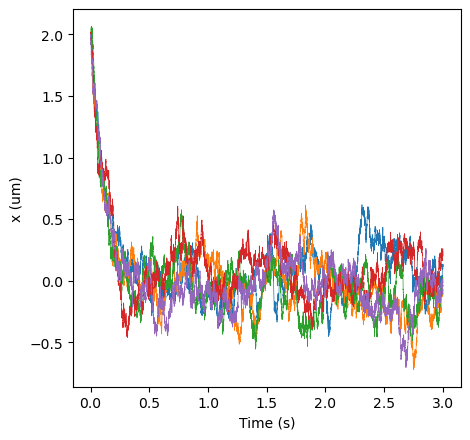

In [29]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)

# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, x0, k, gamma):  # 時間刻み dt で T だけ計算   
    n = int(T / dt)  # ステップ数
    
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
    r = np.random.standard_normal(size = n - 1) # n-1個の正規乱数（平均0, 分散1）を発生．
       
    x = np.zeros(n)
    x[0] = x0 # m/s, 初期位置
    for i in range(n-1):
        f = - k * x[i] # 調和ポテンシャルからうける力
        x[i + 1] = x[i] + dt * f / gamma + w * r[i]
        
    t = np.linspace(0, T - dt, n)
    return t, x


# パラメータ設定
gamma = 1E-8 # (kg/s)
tau = 0.1 # (s) トラップの時定数
k = gamma/tau   # トラップのばね定数
   
T = 3 # (s) 計算時間
dt = 1E-4 # (s) 計算の時間刻み
x0 = 2E-6 # (m) 初期位置．少し離れたところからスタートして，緩和の様子を見てみる．

# 同じ計算を5回して重ねてプロット．

plt.figure(figsize=(5,5), dpi=100)
for i in range(5):
    t, x = langevin(dt, T, x0, k, gamma)  # ランジュバン方程式による計算
    plt.plot(t, x *1E6, lw = 0.5)  # lwは線の太さ．
        
plt.xlabel('Time (s)')
plt.ylabel('x (um)')

plt.show()

# 力学系

## [D1] 固定点

4.1節参照．

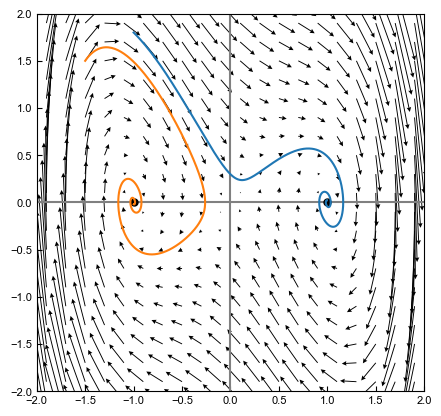

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def func(var, t):
    x = var[0]
    y = var[1]
    dxdt = y
    dydt = -(-2*x+2*x*x*x)-y
    
    return [dxdt, dydt]
    
plt.figure(figsize = (5, 5), dpi = 100)

xmin, xmax, ymin, ymax = -2.5, 2.5, -2.5, 2.5

# 軸をプロット
plt.plot([xmin, xmax], [0, 0], color = 'gray')
plt.plot([0, 0], [ymin,ymax], color = 'gray')

# 安定固定点をプロット
plt.plot(1,0,'o',color='black', markersize = 5)
plt.plot(-1,0,'o',color='black', markersize = 5)

# ベクトル場をプロット
gridwidth=0.2 # メッシュの間隔
X, Y = np.meshgrid(np.arange(xmin, xmax, gridwidth), np.arange(ymin, ymax, gridwidth))  # メッシュを刻む
U, V = func([X, Y], t) # 計算. tはダミー

plt.quiver(X, Y, U, V, scale = 45, headwidth = 5) # プロット．scaleの値が小さいほど矢印が長くなる．

# 時間発展させて，軌跡をプロット．
t = np.linspace(0.0, 10.0, 1000) # 時間
            
init = [-1, 1.8] # 初期値
result = odeint(func, init, t, args=()) # 微分方程式を解く
plt.plot(result[:,0], result[:,1], '-')

init = [-1.5, 1.5]
result = odeint(func, init, t, args=())
plt.plot(result[:,0], result[:,1], '-')

plt.xlim([-2, 2])
plt.ylim([-2, 2])
            
plt.show();

## [D2] ファンデルポール型振動子

4.3節参照．

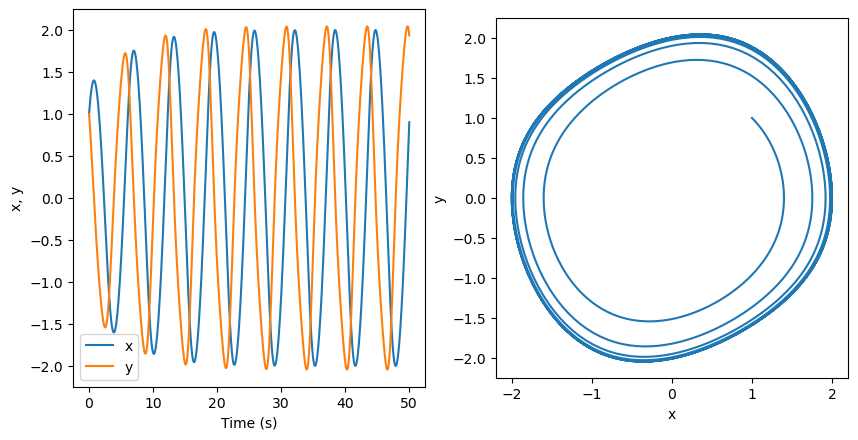

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def func(var, t):
    x, y = var
    dxdt = y
    dydt = -mu*(x*x-1)*y - x
    
    return [dxdt, dydt]

fig = plt.figure(figsize=(10,5), dpi=100)

init = [1, 1]
N = 1000
t = np.linspace(0, 50, N)

mu = 0.2
r = odeint(func, init, t, args = ())

ax1 = fig.add_subplot(121, xlabel = 'Time (s)', ylabel = 'x, y')
ax1.plot(t, r[:,0], label = 'x')
ax1.plot(t, r[:,1], label = 'y')
ax1.legend()

ax2 = fig.add_subplot(122, xlabel = 'x', ylabel = 'y', aspect = 'equal')
ax2.plot(r[:,0], r[:, 1])

plt.show()

## [D3] チューリングパターン

4.6節参照．

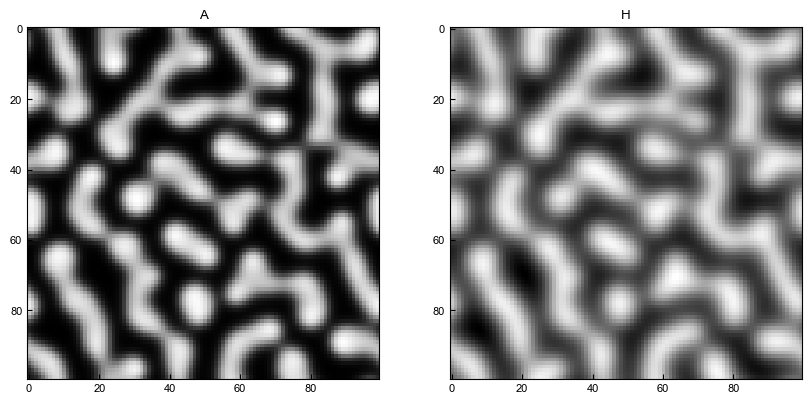

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# 拡散項の計算
def diffusion(f, dx):
    return (-4 * f + np.roll(f,1,axis=0) + np.roll(f,-1,axis=0)+ np.roll(f,+1,axis=1) + np.roll(f,-1,axis=1)) / (dx*dx)

Da, Dh, ka, kh, d = 0.1, 5, 0.2, 0.4, 0.5

L = 100
dx, dt = 0.5, 0.01

# 初期値
a = 0.1*np.random.normal(size=(L, L))
h = 0.1*np.random.normal(size=(L, L))

# 時間発展
for i in range(5000):            
    da = dt * (ka*a*a/(1+a*a)/h-d*a + Da*diffusion(a, dx))
    dh = dt * (kh*a*a/(1+a*a)-d*h + Dh*diffusion(h, dx))
        
    a += da
    h += dh

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi = 100)
    
ax1.imshow(a, cmap='gray')
ax2.imshow(h, cmap='gray')
        
ax1.grid(b = False)
ax2.grid(b = False)
        
ax1.set_title("A")
ax2.set_title("H")

plt.show()

# 分子モーター

# [M1] フラッシングラチェット

8.9節参照．

のこぎり型ポテンシャルとフラットなポテンシャルをperiodごとに周期的切り替える．

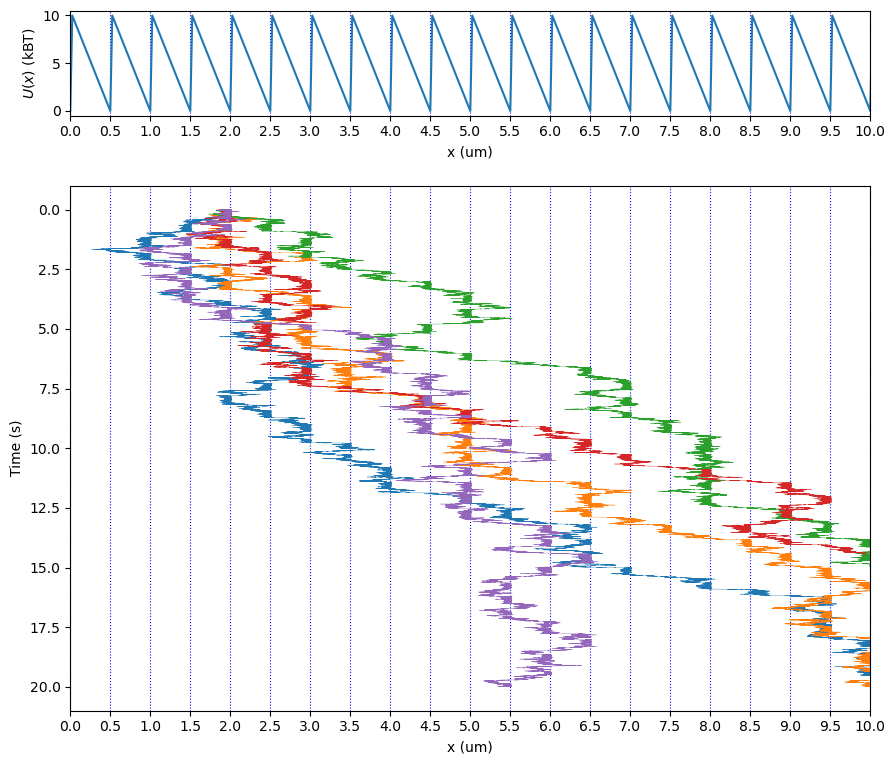

In [225]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)
L = 0.5E-6 # (m)
alpha = 0.05
H = 10*kBT # (kBT)
period = 0.3 # (s)

# パラメータ設定
gamma = 1E-8 # 摩擦係数 (kg/s)
   
T = 20 # (s) 計算時間
dt = 1E-4 # (s) 計算の時間刻み
x0 = 2E-6 # (m) 初期位置．

def U(x):  # のこぎり型ポテンシャル
    xx = x%L
        
    if xx<alpha*L:
        return (H/alpha/L)*xx
    else:
        return H*(1-(xx-alpha*L)/((1-alpha)*L))
    
def dUdx(x):  # のこぎり型ポテンシャルの微分
    xx = x%L   
    
    if xx<alpha*L:
        return H/alpha/L
    else:
        return -H/(1-alpha)/L
    

# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, x0, k, gamma):  # 時間刻み dt で T だけ計算   
    n = int(T / dt)  # ステップ数
    
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
    r = np.random.standard_normal(size = n - 1) # n-1個の正規乱数（平均0, 分散1）を発生．
       
    x = np.zeros(n)
    x[0] = x0 # m/s, 初期位置
    for i in range(n-1):
        if (i*dt) % (2*period) < period:  # periodごとにのこぎり型ポテンシャルとフラット型ポテンシャルを切り替える．
            f = - dUdx(x[i]) # ポテンシャルからうける力
        else:
            f = 0
            
        x[i + 1] = x[i] + dt * f / gamma + w * r[i]
        
    t = np.linspace(0, T - dt, n)
    return t, x

fig = plt.figure(figsize=(8,7), dpi=100)

ax1 = fig.add_axes([0, 0.85, 1, 0.15], xlabel = 'x (um)', ylabel = r'$U(x)$ (kBT)')

ax1.set_xlim([0, 10])
ax1.grid(axis='x',linestyle='dotted', color='b')
ax1.set_xticks(np.linspace(0,10,21))
ax1.grid

# のこぎり型ポテンシャルを表示
x=[]
u=[]
for i in range(22):
    x.append(i*L*1E6)
    u.append(0)
    x.append((i+alpha)*L*1E6)
    u.append(H/kBT)
ax1.plot(x,u)

ax2 = fig.add_axes([0, 0, 1, 0.75], xlabel = 'x (um)', ylabel = 'Time (s)')

# 同じ計算を5回して重ねてプロット．

for i in range(5):
    t, x = langevin(dt, T, x0, k, gamma)  # ランジュバン方程式による計算
    ax2.plot(x *1E6, t, lw = 0.25)  # lwは線の太さ．

    
ax2.grid(axis='x',linestyle='dotted', color='b')
ax2.set_xlim([0, 10])
ax2.set_xticks(np.linspace(0,10,21))
ax2.invert_yaxis()

plt.show()

## [M2] ランダムネス

9.3節参照．

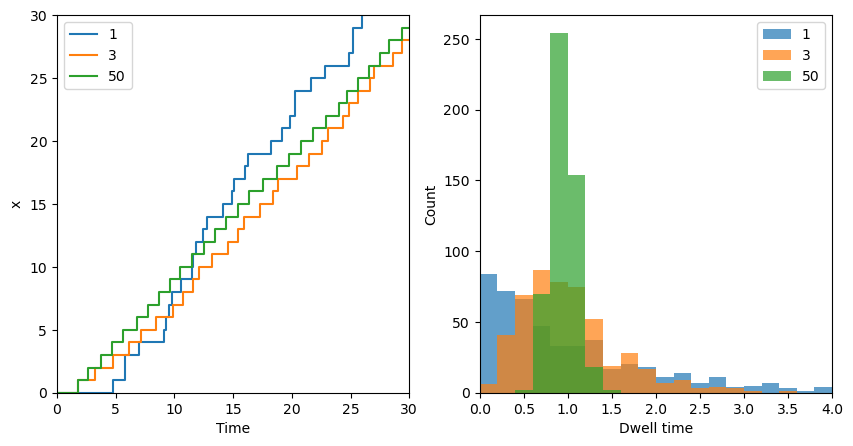

In [39]:
import matplotlib.pyplot as plt
import numpy as np

L = 500         # この距離だけ進んだら修了
tau = 0.001    # 1ステップの時間

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi = 100)

for n in [1,3,50]:    # nは内部状態の数.大きくすると周期的になる．
    w = 1 # 次の場所に移る遷移率
    p = n*w*tau   # 乱数の閾値

    tlist, xlist, duration = [0], [0], []
    
    t=0
    for x in range(L):
        count = 0  # サイコロを振った回数
        for i in range(n):
            while np.random.random() > p:
                count += 1
        t += count*tau

        duration.append(count*tau)

        tlist.append(t)
        xlist.append(x)        
 
    ax1.step(tlist, xlist, where = 'post', label = n) # トラジェクトリをプロット．
    ax2.hist(duration, range = (0, 4), bins = 20, alpha = 0.7, label = n) # ヒストグラムをプロット．

ax1.set_xlabel('Time')
ax1.set_ylabel('x')
ax1.set_xlim([0, 30])
ax1.set_ylim([0, 30])
ax1.legend()

ax2.set_xlabel('Dwell time')
ax2.set_ylabel('Count')
ax2.set_xlim([0,4])
ax2.legend()

plt.show()

## [M3] アレーニウスの関係式 ボツ?

C:\Users\toyabe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


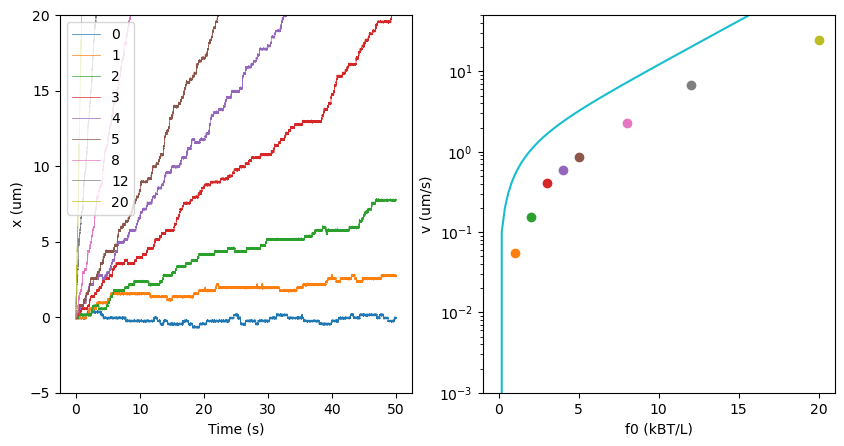

In [232]:
import numpy as np # 計算用ライブラリ
from numpy import cos, sin, pi
import matplotlib.pyplot as plt  # プロット用ライブラリ

kBT = 4.14E-21  # (J = kg m^2 / s^2)
L = 200E-9
a = 3*kBT
    
# メインの関数．ランジュバン方程式をオイラー法で数値積分．
def langevin(dt, T, x0, fex, gamma):  # 時間刻み dt で T だけ計算   
    n = int(T / dt)  # ステップ数
    
    w = np.sqrt(2*kBT*dt/gamma)  # ルートの中にdtを入れる
    r = np.random.standard_normal(size = n - 1) # n-1個の正規乱数（平均0, 分散1）を発生．
       
    x = np.zeros(n)
    x[0] = x0 # m/s, 初期位置
    for i in range(n-1):
        f = - 2*pi*a/L*cos(2*pi*x[i]/L) + fex  # U(x) = a*sin(2*pi*x) - b*x
        x[i + 1] = x[i] + dt * f / gamma + w * r[i]
        
    t = np.linspace(0, T - dt, n)
    return t, x


# パラメータ設定
gamma = 1E-8 # (kg/s)
   
T = 10 # (s) 計算時間
dt = 1E-4 # (s) 計算の時間刻み
x0 = 0 # (m) 初期位置．少し離れたところからスタートして，緩和の様子を見てみる．

# 同じ計算を5回して重ねてプロット．

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi = 100)
for fex in [0, 1, 2, 3 , 4, 5, 8, 12, 20] :
    t, x = langevin(dt, T, x0, fex * kBT/L, gamma)  # ランジュバン方程式による計算
    v = x[-1] / T

    ax1.plot(t, x *1E6, lw = 0.5, label = fex)  # lwは線の太さ．
    ax2.plot(fex, v*1E6, 'o')
    
ff = np.linspace(0, 20, 100) * kBT/L

d = 0.25*L

vv = np.exp(ff*d/kBT) - np.exp(-ff*d/kBT)  # アレーニウスの式から予想される理論式．
ax2.plot(ff/(kBT/L), vv)
        
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('x (um)')
ax1.set_ylim([-5, 20])
ax1.legend()

ax2.set_xlabel('f0 (kBT/L)')
ax2.set_ylabel('v (um/s)')
ax2.set_ylim([0.001, 50])
plt.yscale('log')

plt.show()

# 集団運動

## [S1] ビチェックモデル

14.4節参照．

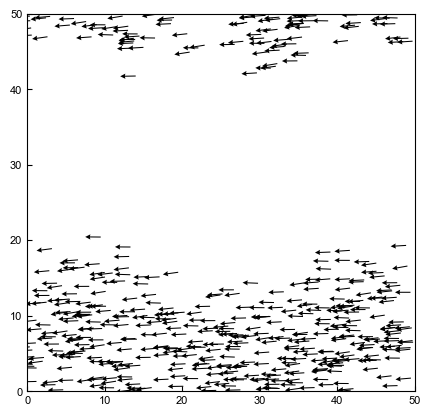

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin, arctan2, random, zeros, pi

v, dt, r, noise = 1, 1, 7, 0.2

N = 500 # 粒子の数
L = 50 # 領域の大きさ

# 初期値
x = random.rand(N)*L
y = random.rand(N)*L
theta = random.rand(N)*2*pi

# 繰り返し
stepN = 100
for i in range(stepN):    
    c = zeros(N)
    s = zeros(N)
    for k in range(N):       
        dx = x[k] - x
        dy = y[k] - y        
        
        dx = (dx + L/2)%L - L/2
        dy = (dy + L/2)%L - L/2
            
        f = dx*dx + dy*dy < r*r
        c[k] = sum(f * cos(theta))
        s[k] = sum(f * sin(theta))

    theta = arctan2(s, c) + (random.rand(N)-0.5)*noise
    
    x = (x + dt*v*cos(theta)) % L
    y = (y + dt*v*sin(theta)) % L
    
plt.figure(figsize=(5,5), dpi = 100)
plt.xlim(0, L)
plt.ylim(0, L)

plt.quiver(x, y, cos(theta), sin(theta), scale = 25, headwidth = 5) # プロット

plt.show()

In [140]:

12 % (2*period)

2